<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Pytorch_logo.png/800px-Pytorch_logo.png" alt="alt text" width="400" height="100">

In [28]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torchvision import transforms

import time
import numpy as np
import matplotlib.pyplot as plt

In [29]:
num_epochs = 5
batch_size = 64
lr = 1e-4

In [30]:
# Create a train and test dataset using the Pytorch MNIST dataloader class
# This inbuilt class will download the MNIST dataset to the provided "root" directory

# Input Parameters:
# root: the directory the dataset is in/should be downloaded to
# train: is this the train split or not? if not it's the test split
# download: if it can't find the dataset in the provided directory should it download the dataset?
# transform: the transform/augmentation to perform on the image data, the images are loaded as PIL images
dataset_train = MNIST(root='.', train=True,  download=True, transform=transforms.ToTensor())
dataset_test  = MNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

# Using the Pytorch dataloader class and the Pytorch datasets
data_loader_train = DataLoader(dataset_train, shuffle=True, batch_size=batch_size, num_workers=0)
data_loader_test = DataLoader(dataset_test, shuffle=False, batch_size=batch_size, num_workers=0)

In [31]:
print("Train DataSET size:", len(dataset_train))
print("Test DataSET size:", len(dataset_test))

Train DataSET size: 60000
Test DataSET size: 10000


In [32]:
print("Train DataLOADER size:", len(data_loader_train))
print("Test DataLOADER size:", len(data_loader_test))

Train DataLOADER size: 938
Test DataLOADER size: 157


In [33]:
# The DataLOADER will loop through a batch of indices and provide them to the dataSET one at a time
# and will "batch" together all the datapoints along the "batch dimension" (dim 0) returning a single tensor
train_data_iter = iter(data_loader_train)
data, labels = next(train_data_iter)
print("Input Data shape", data.shape)
print("Target Data shape", labels.shape)

Input Data shape torch.Size([64, 1, 28, 28])
Target Data shape torch.Size([64])


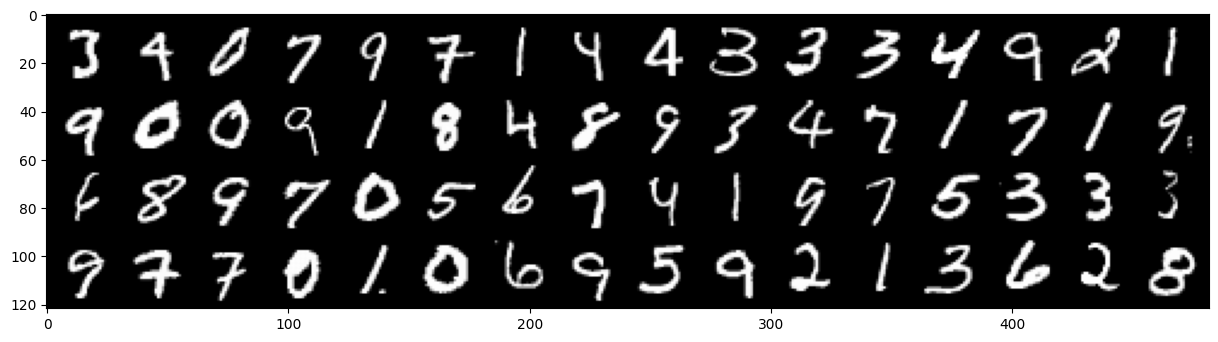

In [34]:
# Visualise an entire batch of images
plt.figure(figsize = (15,10))
out = torchvision.utils.make_grid(data, nrow=16)
plt.imshow(out.numpy().transpose((1, 2, 0)))

<h3> Create an MLP </h3>

In [35]:
#Create a simple 3 layer MLP network
class SimpleMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes):
        super(SimpleMLP, self).__init__()
        self.fc_1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc_2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc_3 = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        # The data passing the model is a batch of single channel images
        # with shape BSx1x28x28 need to be flattened it to BSx784
        # To use it in a linear layer
        bs = x.shape[0]
        x = x.reshape(bs, -1)

        # Use a relu activation function for this network (F.relu)
        # NOTE F.relu is the "functional" version of the activation function!
        # nn.ReLU is a class constructor of a "ReLU" object
        # These two things are the same for MOST purposes!
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))

        # NO activation function on the output!
        # The loss function is 'nn.CrossEntropyLoss' incorporating a SoftMax
        # into the loss to and ensures stability!
        x = self.fc_3(x)
        return x

<h2>Multi-Class Classification </h2>

In [36]:
def training_step(data_batch, target_batch, model, optimizer, loss_func, device):

    # Ensure the data and targets are on the same device as the model
    data_batch = data_batch.to(device)
    target_batch = target_batch.to(device)

    target_pred = model(data_batch)
    loss = loss_func(target_pred, target_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def eval_step(data_batch, target_batch, model, device):
    with torch.no_grad():
        # Ensure the data and targets are on the same device as the model
        data_batch = data_batch.to(device)
        target_batch = target_batch.to(device)

        target_pred = model(data_batch)
        # Take the argmax of the model's output
        predictions = target_pred.argmax(1)

        num_correct = (predictions == target_batch).sum()

        return num_correct.item()

In [37]:
# Function to calulate the accuracy of the model for the given data and labels
def eval_loop(eval_dataloader, model, device):
    total_correct = 0

    # Loop over the data loader
    for data, target in eval_dataloader:
        num_correct = eval_step(data, target, model, device)
        total_correct += num_correct

    return total_correct/len(eval_dataloader.dataset)


# Function to perform the training loop
def training_loop(train_dataloader, val_dataloader, model, optimizer, loss_func, device, num_epochs):

    loss_logger = []
    val_accuracy_logger = []
    train_accuracy_logger = []

    # A single loop over the whole dataset is called an "epoch"
    for epoch in range(num_epochs):
        val_acc = eval_loop(val_dataloader, model, device)
        val_accuracy_logger.append(val_acc)

        train_acc = eval_loop(train_dataloader, model, device)
        train_accuracy_logger.append(train_acc)

        # Loop over the data loader! Much nicer!
        for data, target in train_dataloader:
            # Loop over the mini batches and perform a step of gradient decent every time
            loss = training_step(data, target, model, optimizer, loss_func, device)
            loss_logger.append(loss)

    return loss_logger, train_accuracy_logger, val_accuracy_logger

In [38]:
mlp_net = SimpleMLP(input_size=784, output_size=10, hidden_sizes=[128, 64]).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_net.parameters(), lr=lr)

In [39]:
num_model_params = 0
for param in mlp_net.parameters():
    num_model_params += param.flatten().shape[0]
print("This model has %d Parameters!" % (num_model_params))

This model has 109386 Parameters!


In [40]:
start_time = time.time()
loss_logger, train_acc, val_acc = training_loop(data_loader_train, data_loader_test, mlp_net, optimizer,
                                                loss_function, device, num_epochs=num_epochs)

print("Traing for %d epochs with a batch size of %d took %.2f seconds" %
      (num_epochs, batch_size, time.time() - start_time))

Traing for 5 epochs with a batch size of 64 took 103.15 seconds


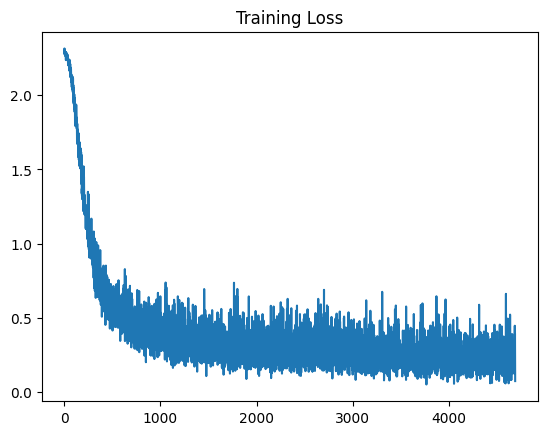

In [41]:
plt.plot(loss_logger)
_ = plt.title("Training Loss")

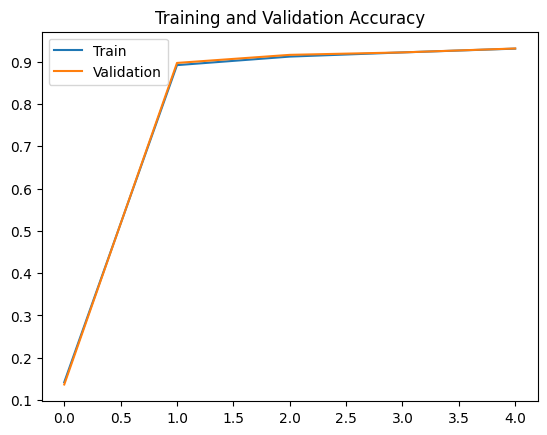

In [42]:
plt.plot(train_acc)
plt.plot(val_acc)
_ = plt.title("Training and Validation Accuracy")
plt.legend(["Train", "Validation"])

In [43]:
test_accuracy = eval_loop(data_loader_test, mlp_net, device)
print("Test Accuracy is %.2f%%" % (100 * test_accuracy))

Test Accuracy is 93.78%
